# Imports:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import interpolate

from jzhou_utils import plot_mean_with_ci, list_files_in_directory, read_obj_pickle

# Helper Functions:

In [34]:
def pooled_mean_stdev(
    df: pd.DataFrame, group_col: str, mean_col="mean", std_col="std", count_col="count",
    std_ddof_input: int = 0,
    std_ddof_output: int = 0,
):
    """
    Compute grouped mean and standard deviation from pre-aggregated stats.

    Parameters:
        df (pd.DataFrame): DataFrame with columns for means, stds, counts, and a groupby column.
        group_col (str): Column to group by.
        mean_col (str): Name of the mean column.
        std_col (str): Name of the std column, computed with ddof = std_ddof_input.
            By default, assumes ddof of input is zero, due to np.std using ddof of zero
        count_col (str): Name of the count column.

    Returns:
        pd.DataFrame: Grouped means and standard deviations.
    """

    def aggregate(group):
        n = group[count_col].values
        m = group[mean_col].values
        s = group[std_col].values

        total_n = n.sum()
        weighted_mean = (n * m).sum() / total_n

        # Pooled variance formula
        pooled_var = ((n - std_ddof_input) * s**2).sum() + (n * (m - weighted_mean) ** 2).sum()
        pooled_var /= total_n - std_ddof_output
        pooled_std = np.sqrt(pooled_var)

        return pd.Series(
            {
                "group_mean": weighted_mean,
                "group_std": pooled_std,
                "group_count": total_n,
            }
        )

    return df.groupby(group_col).apply(aggregate, include_groups=False).reset_index()

In [39]:
def compute_ESS_Meng(biased_sampler):
    """
    Computes the effective sample size based on the mean estimation problem, 
        i.e., based on purely Meng (2018).
    """
    # first compute f (sample / pop), and D_o (as in Meng's paper)
    biased_sampler["f_biased"] = biased_sampler["realized_size_biased"] / 100_000
    biased_sampler["f"] = biased_sampler["sample_size"] / 100_000

    biased_sampler["d_o_intended_indiv"] = biased_sampler.eval("(1 - f) / f")
    biased_sampler["d_o_biased_indiv"] = biased_sampler.eval(
        "(1 - f_biased) / f_biased"
    )

    # d_o computed:
    actual_d_o = biased_sampler.groupby("sample_size")["d_o_biased_indiv"].mean()
    actual_d_o.name = "d_o_biased"
    biased_sampler = pd.merge(biased_sampler, actual_d_o, on="sample_size")

    actual_d_o = biased_sampler.groupby("sample_size")["d_o_intended_indiv"].mean()
    actual_d_o.name = "d_o_intended"
    biased_sampler = pd.merge(biased_sampler, actual_d_o, on="sample_size")

    # compute the data defect correlation, and check whether it is precise enough as well:
    biased_sampler["ddc_biased_squared"] = biased_sampler.eval("ddc_biased ** 2")
    ddc_sq_info = biased_sampler.groupby("sample_size")["ddc_biased_squared"].describe()
    ddc_sq_info["std"] = ddc_sq_info["std"] / np.sqrt(ddc_sq_info["count"])
    # print(
    #     f"Mean of intended data defect correlation vs its mean estimations stdev: {int((ddc_sq_info['mean'] / ddc_sq_info['std']).min())}"
    # )
    ddc_sq_info["d_i_biased"] = ddc_sq_info["mean"]
    biased_sampler = pd.merge(
        biased_sampler, ddc_sq_info["d_i_biased"], on="sample_size"
    )
    
    biased_sampler["ddc_intended_squared"] = biased_sampler.eval("ddc_intended ** 2")
    ddc_sq_info = biased_sampler.groupby("sample_size")[
        "ddc_intended_squared"
    ].describe()
    ddc_sq_info["std"] = ddc_sq_info["std"] / np.sqrt(ddc_sq_info["count"])
    # print(
    #     f"Mean of intended data defect correlation vs its mean estimations stdev: {int((ddc_sq_info['mean'] / ddc_sq_info['std']).min())}"
    # )
    ddc_sq_info["d_i_intended"] = ddc_sq_info["mean"]
    biased_sampler = pd.merge(
        biased_sampler, ddc_sq_info["d_i_intended"], on="sample_size"
    )

    # neff_star according to Meng (2018), Eqn. 3.5:
    biased_sampler["neff_star_biased"] = biased_sampler.eval(
        "1 / (d_i_biased * d_o_biased)"
    )
    biased_sampler["neff_star_intended"] = biased_sampler.eval(
        "1 / (d_i_intended * d_o_intended)"
    )

    # neff here is the effective sample size if we only consider the mean estimation problem,
    # as implied by (3.5) in Meng (2018):
    biased_sampler["neff_biased"] = biased_sampler.eval(
        "neff_star_biased / (1 + (neff_star_biased - 1) / 100_000)"
    )
    biased_sampler["neff_intended"] = biased_sampler.eval(
        "neff_star_intended / (1 + (neff_star_intended - 1) / 100_000)"
    )

    return biased_sampler

# Get population Unit Fisher Information:

In [7]:
population_data = read_obj_pickle('base_population_data_Logit_1.pickle')

In [8]:
pop_x = population_data[["x_0"]]
pop_y = population_data["y"]
pop_model = sm.Logit(endog=pop_y, exog=pop_x).fit(disp=0)
pop_beta = np.array(pop_model.params)
pop_gs = pop_x * (
    np.array(pop_y).reshape((100_000, 1))
    - np.array(pop_model.predict()).reshape((100_000, 1))
)

In [9]:
cov_params = pop_model.cov_params().iloc[0].iloc[0]

inv_unit_FI = cov_params * 100_000

# Read Simulation Data Results:

In [17]:
header_dir = 'sim_results'
srs_dir = 'srs_sim_results'

In [18]:
all_files_in_dir = list_files_in_directory(header_dir, 'pickle')

In [19]:
all_sample_sizes = np.unique([temp_file.split('_')[1] for temp_file in all_files_in_dir]).astype(int)

In [20]:
all_sample_sizes.sort()

In [21]:
all_sample_sizes

array([    6,     7,     9,    11,    13,    16,    20,    25,    30,
          31,    32,    33,    34,    35,    36,    37,    38,    39,
          40,    41,    42,    43,    44,    50,    70,   100,   150,
         200,   250,   300,   350,   400,   500,   600,   700,   800,
         900,  1000,  1400,  2000,  3000,  5000,  7500, 10000, 15000,
       20000])

Per sample size, need to extract:
- avg mse of biased sampling scheme
- effective sample size as implied by Meng (2018), accounting for only the linear impact

In [67]:
all_biased_avg_mses, all_biased_avg_mses_stdev, all_linear_ess, all_linear_ess_2 = (
    [],
    [],
    [],
    [],
)
sims_per_ss = {}

In [68]:
for temp_sample_size in all_sample_sizes:
    # import data for that sample size:
    ss_data = []
    for temp_filename in all_files_in_dir:
        if temp_filename.split("_")[1] == str(temp_sample_size):
            ss_data.append(read_obj_pickle(header_dir + "/" + temp_filename))
    ss_data = pd.concat(ss_data).reset_index(drop=True)

    # compute the necessary statistics:
    biased_sampler = compute_ESS_Meng(ss_data)

    biased_avg_mse = (
        biased_sampler.groupby(by="sample_size")["mse_biased"]
        .mean()
        .reset_index()
        .rename({"mse_biased": "avg_mse"}, axis=1)
    )

    biased_avg_mse_std = (
        (
            biased_sampler.groupby(by="sample_size")["mse_biased"].std()
            / np.sqrt(len(biased_sampler))
        )
        .reset_index()
        .rename({"mse_biased": "avg_mse_std"}, axis=1)
    )

    linear_ess = biased_sampler.groupby(by="sample_size")["neff_biased"].mean()
    
    sims_per_ss[temp_sample_size] = len(biased_sampler)
    all_biased_avg_mses.append(biased_avg_mse)
    all_biased_avg_mses_stdev.append(biased_avg_mse_std)
    all_linear_ess.append(linear_ess)

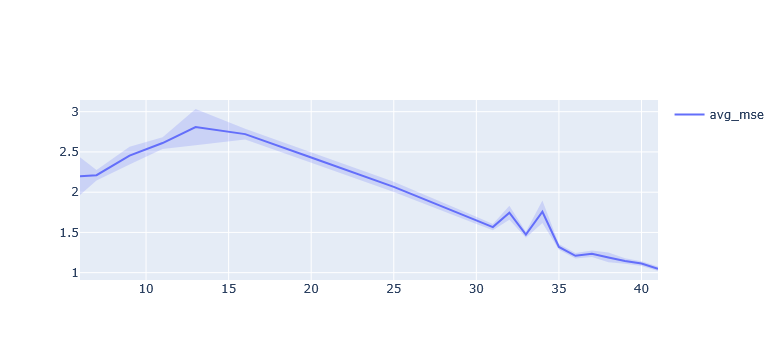

In [66]:
# graphically check if simulated enough, via checking if the means have tight enough CIs
first_n_points = 20
_ = plot_mean_with_ci(
    pd.concat(all_biased_avg_mses).set_index('sample_size')[:first_n_points],
    pd.concat(all_biased_avg_mses_stdev).set_index('sample_size').rename(
        {"avg_mse_std": "avg_mse"}, axis=1
    )[:first_n_points],
)

In [71]:
sims_per_ss[13]

325000

In [72]:
sims_per_ss[9]

325000

In [73]:
sims_per_ss[6]

325000

## Read SRS Simulation Data:

Then, from SRS simulations, we extract the average mean squared error of the intended sampling scheme.

In [42]:
all_srs_avg_mse = []

all_srs_files_in_dir = list_files_in_directory(srs_dir, 'pickle')
for temp_filename in all_srs_files_in_dir:
    all_srs_avg_mse.append(read_obj_pickle(srs_dir + '/' + temp_filename))

all_srs_avg_mse = pd.concat(all_srs_avg_mse)
all_srs_avg_mse.index.name = 'sample_size'
all_srs_avg_mse = all_srs_avg_mse.reset_index()

In [43]:
# rescaling up the stdevs so that it is possible to pull everything together,
# due to the stdev initially the estimated stdev of the mean mse, and not of the raw mses
all_srs_avg_mse["stdev"] = all_srs_avg_mse["stdev"] * np.sqrt(
    all_srs_avg_mse["count"]
)

all_srs_avg_mse = pooled_mean_stdev(all_srs_avg_mse, "sample_size", std_col="stdev")
all_srs_avg_mse['group_std'] /= np.sqrt(all_srs_avg_mse['group_count'])

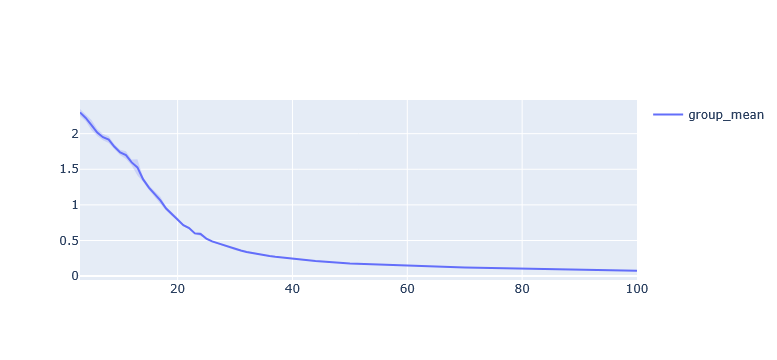

In [45]:
# graphically check if simulated enough, via checking if the means have tight enough CIs
_ = plot_mean_with_ci(
    all_srs_avg_mse.set_index("sample_size")[["group_mean"]],
    all_srs_avg_mse.set_index("sample_size")[["group_std"]].rename(
        {"group_std": "group_mean"}, axis=1
    ),
)

# Concatenate

In [74]:
all_biased_avg_mses = pd.concat(all_biased_avg_mses).reset_index(drop=True)
all_linear_ess = (
    pd.concat(all_linear_ess)
    .reset_index()
    .rename({"neff_biased": "linear_neff"}, axis=1)
)
all_srs_avg_mse = all_srs_avg_mse.rename(
    {"group_mean": "mse_intended"}, axis=1
).set_index("sample_size")["mse_intended"]

# Compute Linearly interpolated Effective Sample Sizes (Actual ESS) + ESS implied from Fisher Information:

In [ ]:
srs_interpolator = interpolate.interp1d(
    x=pd.Series(all_srs_avg_mse.values),
    y=pd.Series(all_srs_avg_mse.index),
    bounds_error=False,
    fill_value=(-1, np.nan),
)

all_biased_avg_mses['interpolated_neff'] = srs_interpolator(all_biased_avg_mses['avg_mse'])
biased_neff_info = pd.merge(all_biased_avg_mses, all_linear_ess, on="sample_size")
biased_neff_info['neff_from_FI'] = inv_unit_FI / biased_neff_info['avg_mse']

# Plots of sample sizes:

In [80]:
biased_neff_info['log10(Intended Sample Size)'] = np.log10(biased_neff_info['sample_size'])
biased_neff_info['log10(Linear ESS)'] = np.log10(biased_neff_info['linear_neff'])
biased_neff_info['log10(Nonlinear Interpolated ESS)'] = np.log10(biased_neff_info['interpolated_neff'])
biased_neff_info['log10(Nonlinear ESS from FI)'] = np.log10(biased_neff_info['neff_from_FI'])

In [81]:
biased_neff_info_filter = (~biased_neff_info["sample_size"].isin(range(31, 45))) | (
    biased_neff_info["sample_size"] == 40
)

In [82]:
biased_neff_info[biased_neff_info_filter].iloc[:10]

,sample_size,avg_mse,interpolated_neff,linear_neff,neff_from_FI,log10(Intended Sample Size),log10(Linear ESS),log10(Nonlinear Interpolated ESS),log10(Nonlinear ESS from FI)
0,6,2.199372,4.216018,9.181829,3.159416,0.778151,0.962929,0.624902,0.499607
1,7,2.210749,4.102709,10.391130,3.143157,0.845098,1.016663,0.613071,0.497366
2,9,2.454692,NaN,12.514574,2.830795,0.954243,1.097416,NaN,0.451908
3,11,2.610598,NaN,13.704093,2.661739,1.041393,1.136850,NaN,0.425165
4,13,2.808496,NaN,14.508871,2.474182,1.113943,1.161634,NaN,0.393432
5,16,2.721559,NaN,15.186187,2.553217,1.204120,1.181449,NaN,0.407088
6,20,2.430815,NaN,16.178593,2.858601,1.301030,1.208941,NaN,0.456154
7,25,2.065339,5.525056,17.240627,3.364450,1.397940,1.236553,0.742337,0.526914
8,30,1.649274,11.480792,18.556688,4.213205,1.477121,1.268500,1.059972,0.624613
18,40,1.113357,16.457516,21.444453,6.241243,1.602060,1.331315,1.216364,0.795271


In [83]:
biased_neff_info['log10(Actual ESS)'] = biased_neff_info['log10(Nonlinear Interpolated ESS)']
biased_neff_info['log10(MLE-Implied ESS)'] = biased_neff_info['log10(Nonlinear ESS from FI)']

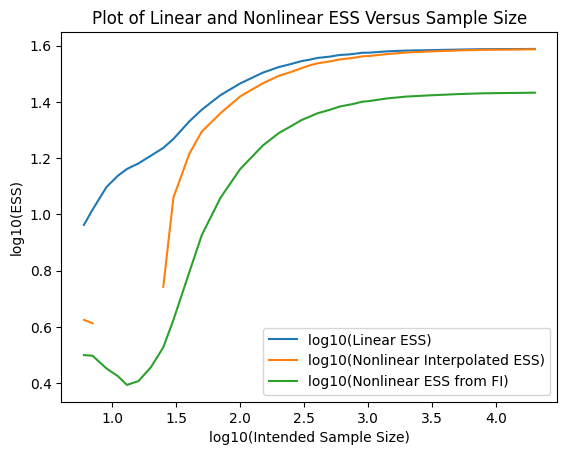

In [84]:
biased_neff_info[biased_neff_info_filter].set_index("log10(Intended Sample Size)")[
    [
        "log10(Linear ESS)",
        "log10(Nonlinear Interpolated ESS)",
        "log10(Nonlinear ESS from FI)",
    ]
].plot()
plt.title("Plot of Linear and Nonlinear ESS Versus Sample Size")
plt.ylabel("log10(ESS)")
plt.savefig("neff_both_ess_over_ss2.png", bbox_inches="tight")

# Plot the Adjustment Factor:

In [85]:
co_val = 99

high_neff_info = biased_neff_info[biased_neff_info['sample_size'] > co_val].copy()
high_neff_info['ESS Adjustment Factor'] = high_neff_info['interpolated_neff'] / high_neff_info['linear_neff']

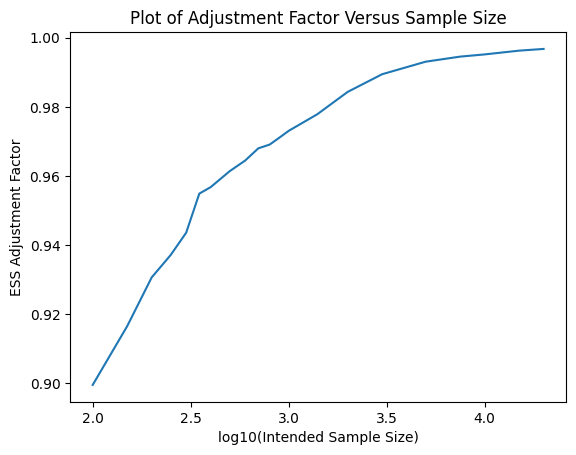

In [86]:
high_neff_info.set_index("log10(Intended Sample Size)")["ESS Adjustment Factor"].plot()
plt.ylabel("ESS Adjustment Factor")
plt.title("Plot of Adjustment Factor Versus Sample Size")
plt.savefig("neff_adjustment_factor.png", bbox_inches="tight")

# Plot Both Together:

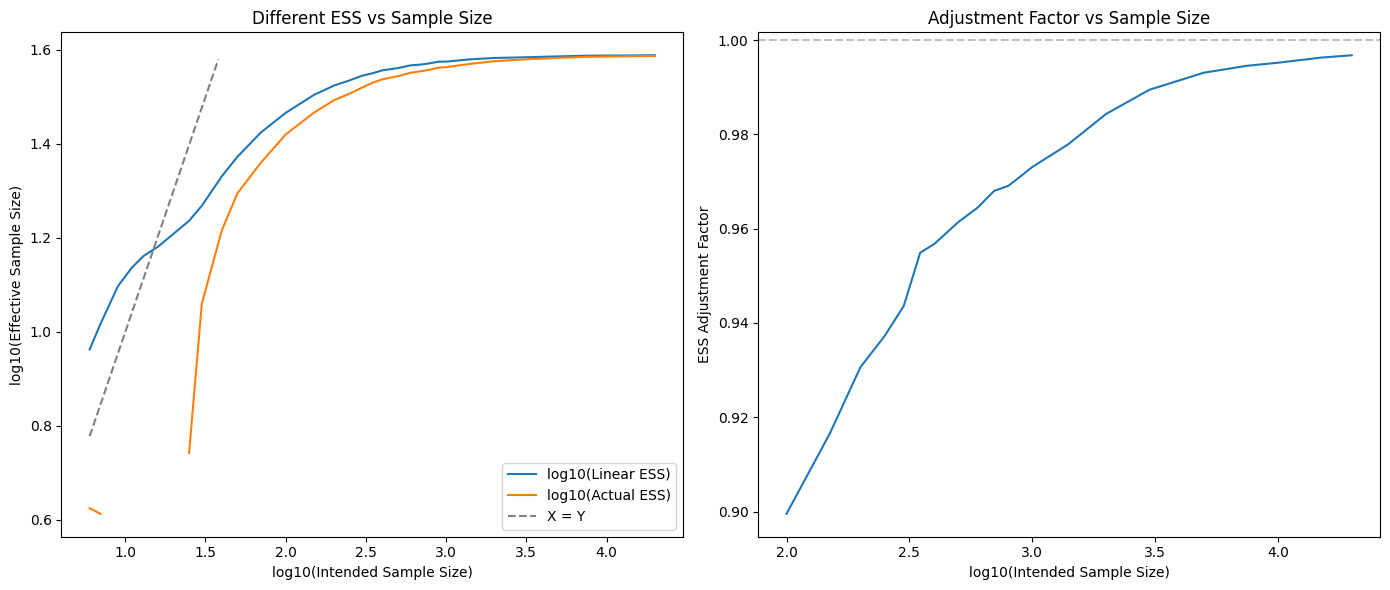

In [87]:
# Create a figure with 2 subplots (horizontal layout)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# First plot: Linear and Nonlinear ESS
biased_neff_info[biased_neff_info_filter].set_index("log10(Intended Sample Size)")[
    [
        "log10(Linear ESS)",
        "log10(Actual ESS)",
    ]
].plot(ax=axes[0])
axes[0].set_title("Different ESS vs Sample Size")
axes[0].set_xlabel("log10(Intended Sample Size)")
axes[0].set_ylabel("log10(Effective Sample Size)")

y_max = biased_neff_info[["log10(Linear ESS)", "log10(Actual ESS)"]].max().max()
x_vals = biased_neff_info["log10(Intended Sample Size)"]
x_y_vals = x_vals[x_vals <= y_max]  # Only keep x where x <= y_max
(x_eq_y_line,) = axes[0].plot(
    x_y_vals, x_y_vals, color="gray", linestyle="--", label="x = y"
)

# Build labels manually
plot_columns = ["log10(Linear ESS)", "log10(Actual ESS)"]
line_labels = plot_columns + ["X = Y"]
handles = axes[0].lines  # includes both the data lines and x=y line
axes[0].legend(handles=handles, labels=line_labels)


# Second plot: ESS Adjustment Factor
high_neff_info.set_index("log10(Intended Sample Size)")["ESS Adjustment Factor"].plot(
    ax=axes[1]
)
axes[1].axhline(
    y=1, color="gray", linestyle="--", alpha=0.5, linewidth=1.5
)  # Dashed horizontal line
axes[1].set_title("Adjustment Factor vs Sample Size")
axes[1].set_xlabel("log10(Intended Sample Size)")
axes[1].set_ylabel("ESS Adjustment Factor")

# Adjust layout and save
plt.tight_layout()
plt.savefig("ess_glm_lite.png", bbox_inches="tight")
plt.show()

### greyscale friendly:

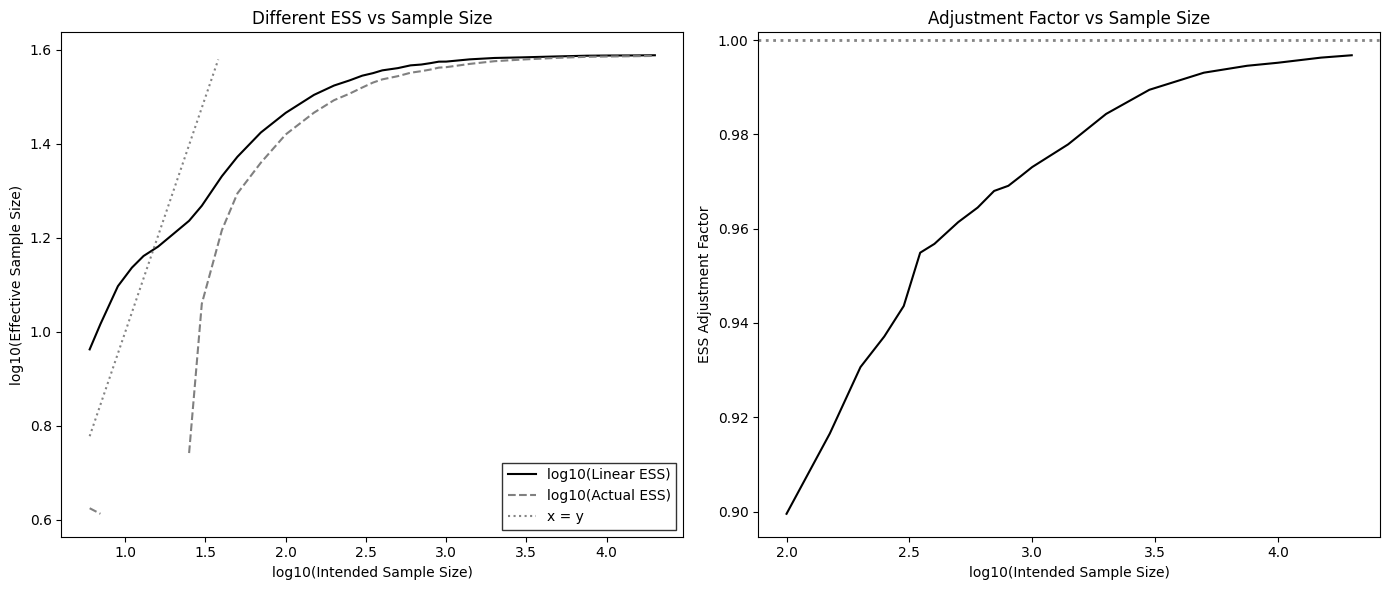

In [88]:
# Set up greyscale-friendly colors and styles
plt.style.use("default")  # Reset any existing style
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ["#000000", "#808080", "#C0C0C0"])

# Define line styles and markers for better distinction
line_styles = ["-", "--", "-.", ":"]
markers = ["o", "s", "^", "D"]
colors = ["#000000", "#808080", "#C0C0C0"]

# Create a figure with 2 subplots (horizontal layout)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# First plot: Linear and Nonlinear ESS
data_subset = biased_neff_info[biased_neff_info_filter].set_index(
    "log10(Intended Sample Size)"
)
plot_columns = ["log10(Linear ESS)", "log10(Actual ESS)"]

# Plot each line manually for better control over styling
for i, col in enumerate(plot_columns):
    axes[0].plot(
        data_subset.index,
        data_subset[col],
        color=colors[i],
        linestyle=line_styles[i],
        label=col,
    )

axes[0].set_title("Different ESS vs Sample Size")
axes[0].set_xlabel("log10(Intended Sample Size)")
axes[0].set_ylabel("log10(Effective Sample Size)")

# Add x=y reference line
y_max = biased_neff_info[["log10(Linear ESS)", "log10(Actual ESS)"]].max().max()
x_vals = biased_neff_info["log10(Intended Sample Size)"]
x_y_vals = x_vals[x_vals <= y_max]  # Only keep x where x <= y_max

(x_eq_y_line,) = axes[0].plot(
    x_y_vals,
    x_y_vals,
    color="#666666",
    linestyle=":",
    # linewidth=2,
    alpha=0.8,
    label="x = y",
)

# Enhanced legend
line_labels = plot_columns + ["x = y"]
axes[0].legend(loc="best", frameon=True, fancybox=False, edgecolor="black")
# axes[0].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Second plot: ESS Adjustment Factor
ess_data = high_neff_info.set_index("log10(Intended Sample Size)")[
    "ESS Adjustment Factor"
]

axes[1].plot(
    ess_data.index,
    ess_data.values,
    color="#000000",
    linestyle="-",
)

# Horizontal reference line at y=1
axes[1].axhline(
    y=1,
    color="#666666",
    linestyle=":",
    alpha=0.8,
    linewidth=2,
)

axes[1].set_title("Adjustment Factor vs Sample Size")
axes[1].set_xlabel("log10(Intended Sample Size)")
axes[1].set_ylabel("ESS Adjustment Factor")

# Adjust layout and save
plt.tight_layout()
plt.savefig(
    "ess_glm_lite_greyscale.png",
    bbox_inches="tight",
    dpi=300,  # Higher resolution
    facecolor="white",
)  # Ensure white background
plt.show()